In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random, jit, grad, vmap, jacfwd, jacrev
import optax
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl

In [ ]:
# Define domain

a = 1.0     # Reference length of the hexagon
r3 = jnp.sqrt(3.0)

xmin = 0
xmax = 3*a
ymin = 0
ymax = r3 * a

# Definition of six points
v1 = jnp.array([0.0, r3 * a / 2.0])
v2 = jnp.array([a / 2.0, r3 * a])
v3 = jnp.array([5.0 * a / 2.0, r3 * a])
v4 = jnp.array([3.0 * a, r3 * a / 2.0])
v5 = jnp.array([5.0 * a / 2.0, 0.0])
v6 = jnp.array([a / 2.0, 0.0])
vertices = jnp.stack([v1, v2, v3, v4, v5, v6])

# Number of sampling points
N_b = 500  # Boundary points
N_r = 1000  # Collocation points

In [ ]:
def generate_points_hexagon(key, N_b, N_r, a, vertices):
    """
    Generates boundary and internal collocation points for the hexagonal domain
    based on the provided vertices.
    """
    key, b_key_t, b_key_i, r_key, r_key_x, r_key_y = jax.random.split(key, 6)

    # --- 1. Boundary Points (BC) ---
    # Samples points proportional to the length of each segment (edge).

    # Cycle through vertices (v1->v2, v2->v3, ..., v6->v1)
    v_start = vertices
    v_end = jnp.roll(vertices, -1, axis=0) # [v2, v3, v4, v5, v6, v1]

    # Calculate the length of each edge
    lengths = jnp.linalg.norm(v_end - v_start, axis=1)
    # lengths = jnp.array([a, 2*a, a, a, 2*a, a]) # Hardcoding is also possible

    # Sampling probabilities (proportional to length)
    probs = lengths / jnp.sum(lengths)

    # Select N_b edge indices based on probabilities
    segment_indices = jax.random.choice(b_key_i, a=jnp.arange(6), shape=(N_b,), p=probs)

    # Uniformly sample N_b interpolation coefficients (t) between 0 and 1
    t = jax.random.uniform(b_key_t, shape=(N_b, 1))

    # Generate points: P = (1-t) * P1 + t * P2
    bc_points = (1 - t) * v_start[segment_indices] + t * v_end[segment_indices]


    # --- 2. Internal Collocation Points (PDE) ---
    # Rejection Sampling

    # 2.1. Define the Bounding Box enclosing the hexagon
    x_min, x_max = 0.0, 3.0 * a
    y_min, y_max = 0.0, r3 * a

    # Hexagon Area / Box Area (Efficiency) ≈ (2.5 * r3 * a^2) / (3 * r3 * a^2) ≈ 83.3%
    # 2x sampling is very safe.
    n_samples_large = int(N_r * 2.0)

    # 2.2. Uniform sampling within the Bounding Box
    x_c_all = jax.random.uniform(r_key_x, minval=x_min, maxval=x_max, shape=(n_samples_large, 1))
    y_c_all = jax.random.uniform(r_key_y, minval=y_min, maxval=y_max, shape=(n_samples_large, 1))

    # 2.3. "Interior" check mask (Point-in-Polygon)
    # For a convex polygon, a point is inside if it lies on the same side of all edges (lines).
    # (Half-Plane intersection)

    # Calculate coefficients (Ax + By + C) for the 6 line equations
    # A = y1 - y2, B = x2 - x1, C = x1*y2 - x2*y1
    A = v_start[:, 1] - v_end[:, 1]  # (6,)
    B = v_end[:, 0] - v_start[:, 0]  # (6,)
    C = v_start[:, 0] * v_end[:, 1] - v_end[:, 0] * v_start[:, 1] # (6,)

    # Determine signs based on an internal point (e.g., Centroid)
    cx = jnp.mean(vertices[:, 0]) # 1.5 * a
    cy = jnp.mean(vertices[:, 1]) # r3 * a / 2.0

    # Signs at the centroid (6,)
    centroid_signs = cx * A + cy * B + C

    # Evaluate 6 line equations for all sample points (N, 6)
    # (n_samples_large, 1) * (6,) -> (n_samples_large, 6)
    line_eqs = x_c_all * A + y_c_all * B + C

    # (N, 6) * (6,) -> (N, 6)
    # If all signs match the centroid's signs (i.e., product is positive), the point is inside
    # jnp.all(..., axis=1) -> (N,)
    mask = jnp.all((line_eqs * centroid_signs) >= 0.0, axis=1)
    mask_flat = mask.flatten()

    # --- Exact N_r sampling using Numpy (Only possible outside JIT) ---
    # Convert JAX arrays to Numpy
    x_c_np = np.array(x_c_all[mask_flat])
    y_c_np = np.array(y_c_all[mask_flat])

    # If more than N_r points are sampled, select only N_r
    if len(x_c_np) >= N_r:
        x_c = jnp.array(x_c_np[:N_r]).reshape(-1, 1)
        y_c = jnp.array(y_c_np[:N_r]).reshape(-1, 1)
    else:
        # Warning if sampling is insufficient (need to increase n_samples_large)
        print(f"Warning: Only {len(x_c_np)} points sampled. Need {N_r}. Increase n_samples_large.")
        x_c = jnp.array(x_c_np).reshape(-1, 1)
        y_c = jnp.array(y_c_np).reshape(-1, 1)

    colloc_points = jnp.concatenate([x_c, y_c], axis=1)

    return bc_points, colloc_points

# --- 2. Execute Point Generation ---
key = jax.random.PRNGKey(42)
bc_points, colloc_points = generate_points_hexagon(key, N_b, N_r, a, vertices)

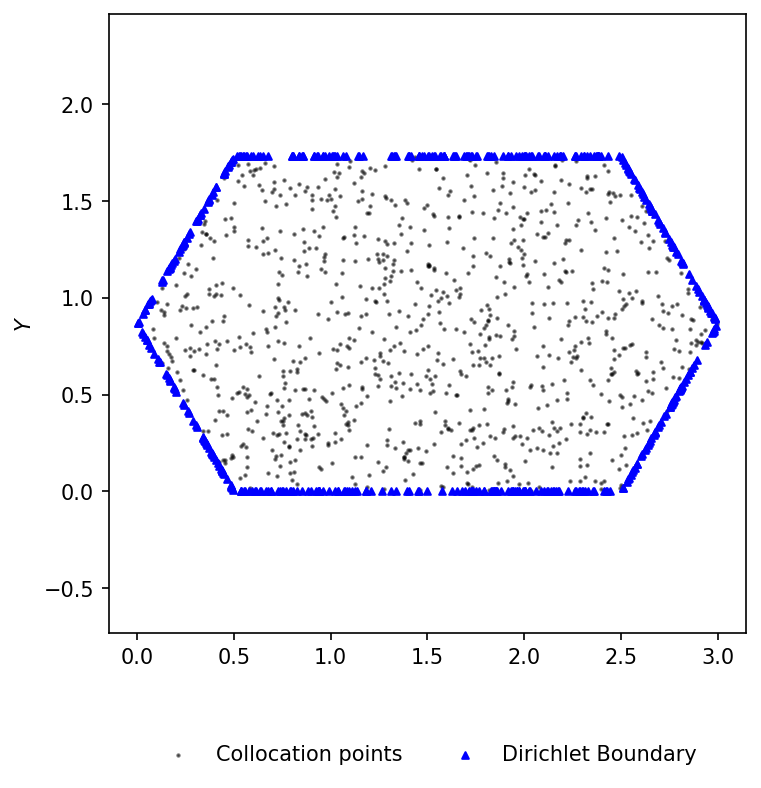

In [ ]:
def plot_sampling(bc_points, colloc_points, vertices):
    bc_np = np.array(bc_points)
    cc_np = np.array(colloc_points)
    v_np = np.array(vertices)
    plt.figure(figsize=(5, 5.5), dpi=150)
    s_colloc = 5
    plt.scatter(cc_np[:, 0], cc_np[:, 1], c='k', marker='.', alpha=0.5, s=s_colloc, label='Collocation points')
    s_bc = 10
    plt.scatter(bc_np[:, 0], bc_np[:, 1], c='blue', marker='^', s=s_bc, label=f'Dirichlet Boundary')
    plt.ylabel('$Y$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.xlim(-0.1, 3.1)
    plt.ylim(-0.1, 1.85)
    plt.axis('equal')
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.95)
    plt.show()

plot_sampling(bc_points, colloc_points, vertices)

In [ ]:
def hydraulic_conductivity(x, y):
  T_x = jnp.ones_like(x)*1.5
  T_y = jnp.ones_like(y)*1.5
  return T_x, T_y

In [ ]:
def pde_residual_2d_darcy(x,y,h):
    """
    Compute the PDE residual for the 2D Laplace equation.

    Inputs:
    x, y: Coordinates of collocation points (N x 1).
    h: Lambda function representing the neural network solution h(x, y).

    Output:
    Residual of the PDE at the collocation points (N x 1).
    """
    T_x, T_y = hydraulic_conductivity(x, y)

    h_x = lambda x,y:jax.grad(lambda x,y:jnp.sum(h(x,y)),0)(x,y)
    h_xx = lambda x,y:jax.grad(lambda x,y:jnp.sum(h_x(x,y)),0)(x,y)

    h_y=lambda x,y:jax.grad(lambda x,y:jnp.sum(h(x,y)),1)(x,y)
    h_yy=lambda x,y:jax.grad(lambda x,y:jnp.sum(h_y(x,y)),1)(x,y)

    return T_x*h_xx(x,y) + T_y*h_yy(x,y) + 1e-5/(1e-4)**2

In [ ]:
# Define Neural Network Architecture
def neural_net(params, x, y):
    """
    Forward pass of a neural network to predict h(x, y).

    Inputs:
    params: Neural network parameters (list of weights and biases).
    x, y: Input coordinates (N x 1).

    Output:
    Predicted h(x, y) values (N x 1).
    """
    X = jnp.concatenate([x, y],axis=1)
    *hidden,last = params
    for layer in hidden :
        X = jax.nn.tanh(X@layer['W']+layer['B'])
    return X@last['W'] + last['B']


# Function to initialize parameters of the neural network (weights and biases)
def init_params(layers):
    """
    Initialize parameters (weights and biases) for a neural network with specified layers.

    Args:
        layers: List of integers representing the number of nodes in each layer.
                For example, [2, 20, 20, 1] creates a network with input layer (2 nodes),
                two hidden layers (20 nodes each), and an output layer (1 node).

    Returns:
        params: List of dictionaries containing 'W' (weights) and 'B' (biases) for each layer.
    """
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)  # Generate random keys for each layer
    params = list()  # Initialize a list to store layer parameters

    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):  # Loop through layer dimensions
        lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in))  # Xavier initialization bounds
        W = lb + (ub - lb) * jax.random.uniform(key, shape=(n_in, n_out))  # Initialize weights
        B = jax.random.uniform(key, shape=(n_out,))  # Initialize biases
        params.append({'W': W, 'B': B})  # Append layer parameters (weights and biases) to the list

    return params  # Return the initialized parameters

In [ ]:
@jax.jit
def loss_fun(params, colloc, conds):
    h_nn = lambda x, y: neural_net(params, x, y)

    # PDE residual
    x_c, y_c = colloc[:, [0]], colloc[:, [1]]
    pde_res_c = pde_residual_2d_darcy(x_c, y_c, h_nn)
    pde_loss = jnp.mean(pde_res_c**2)

    # Dirichlet BC loss
    dbc_loss = 0.0
    for cond in conds[0:2]:
        x_b, y_b, u_b = cond[:, [0]], cond[:, [1]], cond[:, [2]]
        dbc_loss += jnp.mean((h_nn(x_b, y_b) - u_b)**2)

    loss = 1 * pde_loss + 100 * dbc_loss

    return loss

In [ ]:
# Generate boundary conditions

# Boundary values (h)
# Set h = 0.0 for all boundary points (N_b)
h_b_all = jnp.zeros((N_b, 1))

# Concatenate (x, y, h) data
# Concatenate bc_points (N_b, 2) and h_b_all (N_b, 1)
dbc_all_boundaries = jnp.concatenate([bc_points, h_b_all], axis=1)

# Create 'conds' list
# Wrap in a list for passing, as loss_fun iterates through the list
bc_conds = [dbc_all_boundaries]


# --- PINN prediction and plotting results ---
nx = 101
x = np.linspace(xmin, xmax, nx)
dx = x[1] - x[0]
ny = 101
y = np.linspace(ymin, ymax, ny)
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)
X_flat = X.flatten().reshape(-1, 1)
Y_flat = Y.flatten().reshape(-1, 1)

In [ ]:
# Define hyperparameters for the neural network and training
hidden_nodes = 30      # Number of nodes in each hidden layer
hidden_layers = 3      # Number of hidden layers in the neural network
initial_learning_rate = 1e-2
lr_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=5000,
    decay_rate=0.8
)
epochs = 50000

# Construct the MLP (Multilayer Perceptron) using the specified architecture
key, pkey = jax.random.split(key, 2)
params = init_params([2] + [hidden_nodes] * hidden_layers + [1])

# Define the optimizer (Adam optimizer with the specified learning rate)
optimizer = optax.adam(learning_rate = lr_schedule)
opt_state = optimizer.init(params)

@jax.jit
def update(opt_state, params, colloc, conds):
    grads = jax.grad(loss_fun, 0)(params, colloc, conds)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

# --- PINN training loop ---
print('PINN training started...')

best_params = params
best_loss = float('inf')
best_epoch = 0
all_losses = []
all_epochs = []

for epoch in range(epochs+1):
    opt_state, params = update(opt_state, params, colloc_points, bc_conds)

    if epoch % 100 == 0:
        current_loss = loss_fun(params, colloc_points, bc_conds)

        all_losses.append(current_loss)
        all_epochs.append(epoch)

        if current_loss < best_loss:
            best_loss = current_loss
            best_params = params
            best_epoch = epoch

        print(f'Epoch={epoch}\tloss={current_loss:.3e}')


print('PINN training done!')
print(f'Best Epoch = {best_epoch}\tBest Loss = {best_loss:.3e}')

PINN training started...
Epoch=0	loss=9.996e+05
Epoch=100	loss=6.356e+05
Epoch=200	loss=3.076e+05
Epoch=300	loss=1.808e+05
Epoch=400	loss=1.239e+05
Epoch=500	loss=8.628e+04
Epoch=600	loss=5.551e+04
Epoch=700	loss=3.760e+04
Epoch=800	loss=2.654e+04
Epoch=900	loss=1.771e+04
Epoch=1000	loss=1.233e+04
Epoch=1100	loss=1.022e+04
Epoch=1200	loss=1.090e+04
Epoch=1300	loss=5.300e+03
Epoch=1400	loss=3.877e+03
Epoch=1500	loss=3.381e+03
Epoch=1600	loss=2.499e+03
Epoch=1700	loss=2.470e+03
Epoch=1800	loss=4.029e+03
Epoch=1900	loss=1.773e+03
Epoch=2000	loss=1.472e+03
Epoch=2100	loss=1.688e+03
Epoch=2200	loss=2.651e+03
Epoch=2300	loss=1.997e+03
Epoch=2400	loss=2.617e+03
Epoch=2500	loss=1.453e+03
Epoch=2600	loss=2.251e+03
Epoch=2700	loss=1.279e+04
Epoch=2800	loss=8.305e+02
Epoch=2900	loss=1.352e+03
Epoch=3000	loss=5.587e+03
Epoch=3100	loss=1.872e+03
Epoch=3200	loss=1.087e+03
Epoch=3300	loss=1.207e+03
Epoch=3400	loss=7.230e+02
Epoch=3500	loss=3.699e+03
Epoch=3600	loss=2.278e+03
Epoch=3700	loss=1.124e+03

Detected Grid: 61x35

--- Random Sampling (30%) ---
Total Valid Cells: 1779
Selected Points: 533
RMSE (sampled 30%): 14.5423 m


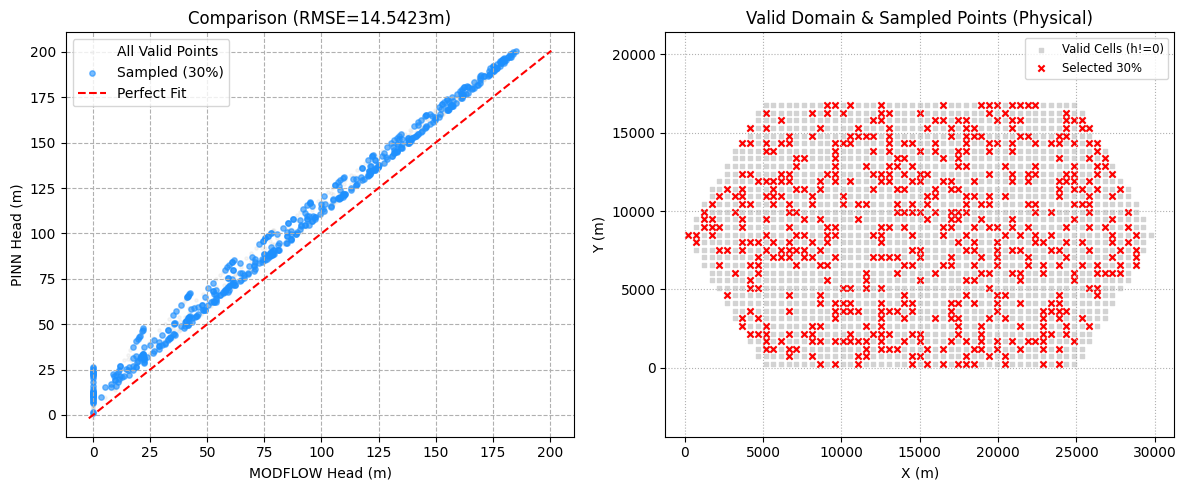

In [ ]:
base_path = os.getcwd()
data_folder = os.path.join(base_path, 'data')
file_name = 'Case5.txt'
file_path = os.path.join(data_folder, file_name)

# Check file existence and load
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Can not find data file: {file_path}")

try:
    # Load data
    df = pd.read_csv(file_name, skipinitialspace=True)
    df.columns = df.columns.str.replace('"', '').str.strip()

    # Filtering Active Cell and delete h=0
    if 'Active' in df.columns:
        df_temp = df[df['Active'] == 1].copy()
    else:
        df_temp = df[(df['f'] > -1000) & (df['f'] < 10000)].copy()

    df_active = df_temp

    # Grid information
    Nx_mf = df['j'].max() # 61
    Ny_mf = df['i'].max() # 35

    # Real physical scale in MODFLOW
    L_x_phys = 30000.0
    L_y_phys = 17000.0

    dx_phys = L_x_phys / Nx_mf
    dy_phys = L_y_phys / Ny_mf

    print(f"Detected Grid: {Nx_mf}x{Ny_mf}")

    # MODFLOW Index -> Physical -> Normalized

    # (1) Physical coordinates (meters)
    df_active['x_phys'] = (df_active['j'] - 0.5) * dx_phys
    df_active['y_phys'] = L_y_phys - (df_active['i'] - 0.5) * dy_phys # Top-down

    # (2) Normalized coordinates (for PINN input, range 0~3.0)
    # In the PINN code, when a=1.0, xmax=3*a=3.0, ymax=sqrt(3)*a=1.732.
    # Therefore, dividing MODFLOW coordinates by 10000 gives PINN coordinates.

    scale_factor = 10000.0 # [Key Correction] Scaling factor

    df_active['x_norm'] = df_active['x_phys'] / scale_factor
    df_active['y_norm'] = df_active['y_phys'] / scale_factor

    # 6. PINN Prediction
    x_in = df_active['x_norm'].values.reshape(-1, 1)
    y_in = df_active['y_norm'].values.reshape(-1, 1)
    x_jax = jnp.array(x_in)
    y_jax = jnp.array(y_in)

    if 'best_params' not in locals():
        raise NameError("best_params is undefined. Train the model first.")

    h_pinn_all = neural_net(best_params, x_jax, y_jax)
    h_mf_all = df_active['f'].values.reshape(-1, 1)

    # =========================================================
    # [Random Sampling] Extract 30% and calculate RMSE
    # =========================================================
    N_total = len(h_mf_all)
    if N_total == 0:
        raise ValueError("No valid data points left.")

    n_samples = int(N_total * 0.30)

    print(f"\n--- Random Sampling (30%) ---")
    print(f"Total Valid Cells: {N_total}")
    print(f"Selected Points: {n_samples}")

    rng = np.random.default_rng(seed=42)
    random_indices = rng.choice(N_total, size=n_samples, replace=False)

    h_pinn_sampled = h_pinn_all[random_indices]
    h_mf_sampled = h_mf_all[random_indices]

    diff = h_pinn_sampled - h_mf_sampled
    rmse = np.sqrt(np.mean(diff**2))

    print(f"RMSE (sampled 30%): {rmse:.4f} m")

    # --- 7. Visualization ---
    plt.figure(figsize=(12, 5))

    # (1) Parity Plot
    plt.subplot(1, 2, 1)
    plt.scatter(h_mf_all, h_pinn_all, alpha=0.1, s=5, c='lightgray', label='All Valid Points')
    plt.scatter(h_mf_sampled, h_pinn_sampled, alpha=0.6, s=15, c='dodgerblue', label='Sampled (30%)')

    min_val = min(h_mf_all.min(), h_pinn_all.min())
    max_val = max(h_mf_all.max(), h_pinn_all.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')

    plt.xlabel("MODFLOW Head (m)")
    plt.ylabel("PINN Head (m)")
    plt.title(f"Comparison (RMSE={rmse:.4f}m)")
    plt.legend()
    plt.grid(True, linestyle='--')

    # (2) Active Cell & Sampled Location Plot
    plt.subplot(1, 2, 2)

    x_all = df_active['x_phys'].values
    y_all = df_active['y_phys'].values
    x_sampled = x_all[random_indices]
    y_sampled = y_all[random_indices]

    # Valid data area (h != 0) - Displayed in physical coordinates
    plt.scatter(x_all, y_all, s=10, c='lightgray', marker='s', label='Valid Cells (h!=0)')
    # Sampled locations
    plt.scatter(x_sampled, y_sampled, s=20, c='r', marker='x', label='Selected 30%')

    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.title("Valid Domain & Sampled Points (Physical)")
    plt.legend(loc='upper right', fontsize='small')
    plt.axis('equal')
    plt.grid(True, linestyle=':')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")

In [ ]:
#  Maximum PINN prediction
max_pinn = np.max(h_pinn_all)
print(f"PINN Predicted Max Head: {max_pinn:.4f} m")

# (For comparison) Maximum MODFLOW actual head
max_mf = np.max(h_mf_all)
print(f"MODFLOW Actual Max Head: {max_mf:.4f} m")

PINN 예측 최대 수두 (Max Head): 200.6330 m
MODFLOW 실제 최대 수두 (Max Head): 185.2799 m


TypeError: Cannot index by location index with a non-integer key

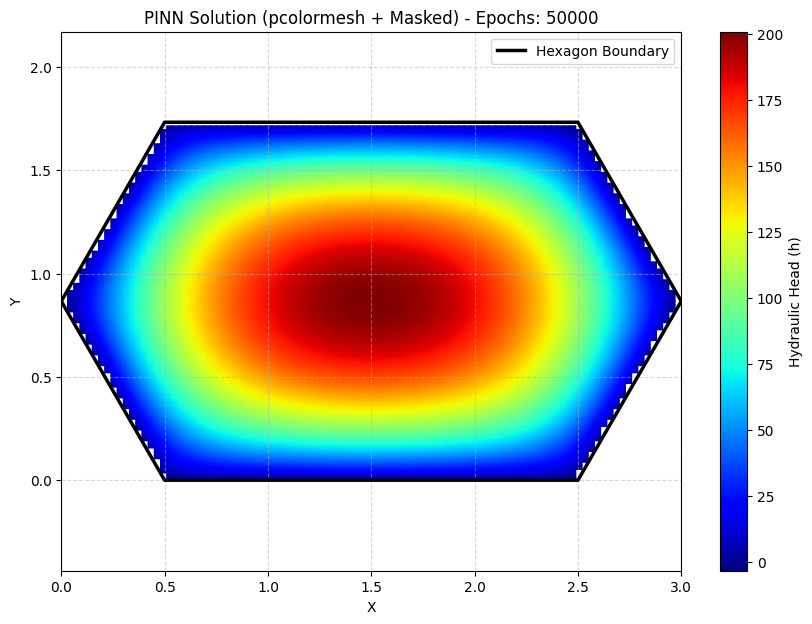

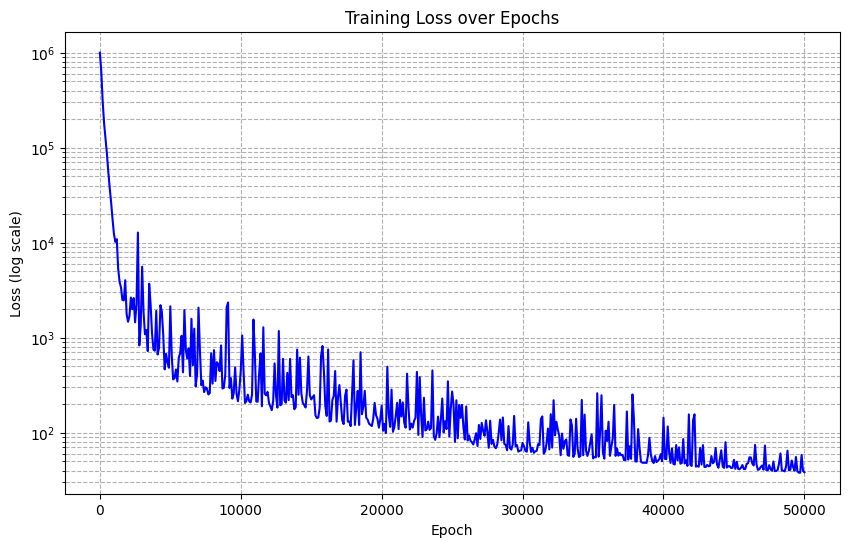

In [ ]:
# --- Visualization of Results (pcolormesh + Data Masking) ---

# Final Prediction
pinn_h_flat = neural_net(best_params, X_flat, Y_flat)

# Masking area outside the hexagon (NaN treatment)
v_start = vertices
v_end = jnp.roll(vertices, -1, axis=0)
A = v_start[:, 1] - v_end[:, 1]
B = v_end[:, 0] - v_start[:, 0]
C = v_start[:, 0] * v_end[:, 1] - v_end[:, 0] * v_start[:, 1]
cx = jnp.mean(vertices[:, 0])
cy = jnp.mean(vertices[:, 1])
centroid_signs = cx * A + cy * B + C

line_eqs = X_flat * A + Y_flat * B + C
mask = jnp.all((line_eqs * centroid_signs) >= 0.0, axis=1)

pinn_h_flat_masked = jnp.where(mask.reshape(-1, 1), pinn_h_flat, jnp.nan)

pinn_h = pinn_h_flat_masked.reshape(nx, ny)
pinn_h_np = np.array(pinn_h)

# Create Plot and Axes (Figure, Axes)
fig, ax = plt.subplots(figsize=(10, 7))

# Use pcolormesh (Resolves gap issues)
# shading='gouraud' provides smooth interpolation.
# np.nanmin/nanmax ignores NaNs and finds the min/max of actual data.
cf = ax.pcolormesh(X, Y, pinn_h_np, shading='gouraud', cmap=cm.jet,
                   vmin=np.nanmin(pinn_h_np), vmax=np.nanmax(pinn_h_np))
plt.colorbar(cf, label='Hydraulic Head (h)')

# Draw Hexagon Boundary
v_np = np.array(vertices)
hexagon_plot = np.concatenate([v_np, v_np[0:1]], axis=0)
ax.plot(hexagon_plot[:, 0], hexagon_plot[:, 1],
         'k-', lw=2.5, label='Hexagon Boundary')

# Plot Settings
ax.set_title(f'PINN Solution (pcolormesh + Masked) - Epochs: {epochs}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.axis('equal')
ax.grid(True, linestyle='--', alpha=0.5)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.show()

# Loss Function Graph (Same as before)
plt.figure(figsize=(10, 6))
plt.plot(all_epochs, all_losses, 'b-')
plt.yscale('log')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.grid(True, which="both", ls="--")
plt.show()